# *Animal Classification using Transfer Learning Model (MobileNetV2)*

Connect colab runtime to GPU

Importing Libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D, Input
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

Connecting to Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzipping image folder

!unzip /content/drive/MyDrive/animal.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-e6H3_aCtzXyxuExfwTHcVwHaE8.jpeg  
  inflating: raw-img/ragno/OIP-e6iXA-V3QbOBiNsPY-TfSQHaFj.jpeg  
  inflating: raw-img/ragno/OIP-E89tGEuaZ4wzBvIYvxOEjAHaGL.jpeg  
  inflating: raw-img/ragno/OIP-E-8HCNdrTI2Q-ujYynhRIgHaGZ.jpeg  
  inflating: raw-img/ragno/OIP-e8qNiF8Wvmqb-k9kucrzfAHaF4.jpeg  
  inflating: raw-img/ragno/OIP-e8x0rOA9DEq3agEGbUdwawHaFj.jpeg  
  inflating: raw-img/ragno/OIP-e98qfAwKXAhDWF2DGtrA7gHaFj.jpeg  
  inflating: raw-img/ragno/OIP-e9IDQCZespp1d4zQTNH-lwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-e9Mz3MvWwYqtYwC8bsmxIAHaF0.jpeg  
  inflating: raw-img/ragno/OIP-E9NM2O8ncDHm_M0iuVpfUgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-e9UXRB7FVnKMmSaOmi__FwHaEw.jpeg  
  inflating: raw-img/ragno/OIP-Ea0THN3uA_gVU7hRslUPgQEBDy.jpeg  
  inflating: raw-img/ragno/OIP-EAdj8g0LKmohsporuwROcwHaE8.jpeg  
  inflating: raw-img/ragno/OIP-EAIevrcUPiFf0RmZ1Y_W5AHaE3.jpeg  
  inflating: raw-img/ragno/OIP-EakMWkDk

Using Python Dictionary present in animal_classification folder for renaming folders

In [4]:
from translate import translate

translate

{'cane': 'dog',
 'cavallo': 'horse',
 'elefante': 'elephant',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'scoiattolo': 'squirrel',
 'dog': 'cane',
 'elephant': 'elefante',
 'butterfly': 'farfalla',
 'chicken': 'gallina',
 'cat': 'gatto',
 'cow': 'mucca',
 'ragno': 'spider',
 'squirrel': 'scoiattolo',
 'spider': 'ragno'}

In [5]:
!unzip /content/animal.zip

unzip:  cannot find or open /content/animal.zip, /content/animal.zip.zip or /content/animal.zip.ZIP.


Renaming folder names

In [6]:
for i in os.listdir('raw-img'):
  os.rename('raw-img/' + i, 'raw-img/' + translate[i])



Displaying folder names

In [7]:
for i in os.listdir('raw-img'):
  print(i)

butterfly
spider
horse
cow
dog
cat
chicken
sheep
squirrel
elephant


Displaying No. of Images in each folder

In [8]:
for i in os.listdir('raw-img'):
  print(i, len(os.listdir('raw-img/' + i)))

butterfly 2112
spider 4821
horse 2623
cow 1866
dog 4863
cat 1668
chicken 3098
sheep 1820
squirrel 1862
elephant 1446


Creating new directories

And Entering data in new directories

In [9]:
os.mkdir('train')
os.mkdir('test')

for i in os.listdir('raw-img'):
  os.mkdir('train/' + i)
  os.mkdir('test/' + i)

  for j in os.listdir('raw-img/'+i)[:1000]:
    os.rename('raw-img/'+i+'/'+j, 'train/'+i+'/'+j)
  for j in os.listdir('raw-img/'+i)[:400]:
    os.rename('raw-img/'+i+'/'+j, 'test/'+i+'/'+j)

  #train dataset contains 1000 images while test dataset contains 400 images

Creating function for Image Data Generator.

In [10]:
def img_data(dir_path, target_size, batch, class_lst, pre_processs):
  if pre_processs:
    generate_object = ImageDataGenerator(preprocessing_function=pre_processs)
  else:
    generate_object = ImageDataGenerator()

  return (generate_object.flow_from_directory(dir_path, target_size=target_size, batch_size=batch,  #using flow_from_directory because all of our data is saved in form of directories.
                                              class_mode='sparse', classes=class_lst, shuffle=True))

In [11]:
train_data_gen = img_data('train', (224, 224), 500, os.listdir('train'), preprocess_input)
# mobilenet. preprocess_input will scale input pixels between -1 and 1. input_shape: Optional shape tuple,
# only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
# (with channels_last data format) or (3, 224, 224) (with channels_first data format).

valid_data_gen = img_data('test', (224, 224), 500, os.listdir('test'), preprocess_input)

Found 10000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


Transfer Learning With MobileNet V2. MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. *We will use this as our base model* to train with our dataset and classify the images of animals

In [12]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

9406464/9406464 [==============================] - 0s 0us/step


Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [13]:
base_model.trainable=False

Creating our Image Classification Model

In [14]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(GlobalAvgPool2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# This callback will stop the training when there is no improvement in # the loss for three consecutive epochs.

elst = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [17]:

# ModelCheckpoint callback allows you to continually save the model both during and at the end of training.
# Model will saved in our drive ('MyDrive/animal_classification')

save_ck = callbacks.ModelCheckpoint('/content/mdl_wti.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [18]:
model.fit(train_data_gen, batch_size=500, validation_data=valid_data_gen, callbacks=[elst, save_ck], epochs=10)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.8505

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 64s 3s/step - loss: 0.5337 - accuracy: 0.8505 - val_loss: 0.1622 - val_accuracy: 0.9523
Epoch 2/10
20/20 [==============================] - 43s 2s/step - loss: 0.1434 - accuracy: 0.9564 - val_loss: 0.1579 - val_accuracy: 0.9515
Epoch 3/10
20/20 [==============================] - 43s 2s/step - loss: 0.0940 - accuracy: 0.9725 - val_loss: 0.1398 - val_accuracy: 0.9557
Epoch 4/10
20/20 [==============================] - 42s 2s/step - loss: 0.0642 - accuracy: 0.9835 - val_loss: 0.1534 - val_accuracy: 0.9532
Epoch 5/10
20/20 [==============================] - 42s 2s/step - loss: 0.0480 - accuracy: 0.9885 - val_loss: 0.1509 - val_accuracy: 0.9550
Epoch 6/10
20/20 [==============================] - 42s 2s/step - loss: 0.0347 - accuracy: 0.9935 - val_loss: 0.1421 - val_accuracy: 0.9550
Epoch 7/10
20/20 [==============================] - 43s 2s/step - loss: 0.0239 - accuracy: 0.9962 - val_loss: 0.1439 - val_accuracy: 0.9560
Epoch 8/10
20/20 [=============

#Testing using random images

1/1 [==============================] - 1s 1s/step


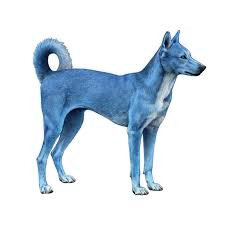

Predicted: Dog


In [32]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_v2_preprocess_input
from google.colab.patches import cv2_imshow

# Load the pre-trained model
model = tf.keras.models.load_model("/content/mdl_wti.hdf5")

# Dictionary mapping indices to class labels
map_dict = {0: 'sheep', 1: 'butterfly', 2: 'cat', 3: 'squirrel', 4: 'Dog', 5: 'dog', 6: 'elephant', 7: 'horse', 8: 'cow', 9: 'spider'}

# List of image paths
image_paths = ["/content/do.jpeg"]  # Add more image paths

for image_path in image_paths:
    opencv_image = cv2.imread(image_path)
    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(opencv_image, (224, 224))
    resized = mobilenet_v2_preprocess_input(resized)
    img_reshape = resized[np.newaxis, ...]

    # Perform inference
    prediction = model.predict(img_reshape).argmax()
    predicted_label = map_dict[prediction]

    # Display the image
    cv2_imshow(opencv_image)
    print(f"Predicted: {predicted_label}")

    cv2.waitKey(0)  # Wait for a key press to move to the next image

cv2.destroyAllWindows()
